# importing libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer=WordNetLemmatizer()
import demoji
demoji.download_codes()
from nltk import punkt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

C:\Users\user\AppData\Local\Temp\ipykernel_24308\543558942.py:14: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


# EDA

In [2]:
#downloading the datasets
od.download('https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data')

Skipping, found downloaded files in ".\twitter-entity-sentiment-analysis" (use force=True to force download)


In [3]:
#loading the datasets
train_df=pd.read_csv('twitter-entity-sentiment-analysis/twitter_training.csv')
val_df=pd.read_csv('twitter-entity-sentiment-analysis/twitter_validation.csv')

In [4]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
val_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [6]:
#checking the null values
train_df.isnull().sum()

2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64

In [7]:
training_df=train_df.dropna()

In [8]:
training_df.shape

(73995, 4)

In [9]:
#checking the duplicate calues
training_df.duplicated().sum()

np.int64(2340)

In [10]:
training_df.drop_duplicates(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_24308\2976901019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df.drop_duplicates(inplace=True)


In [11]:
#renaming the datasets columns
training_df.columns=['id','category','response','Tweet']

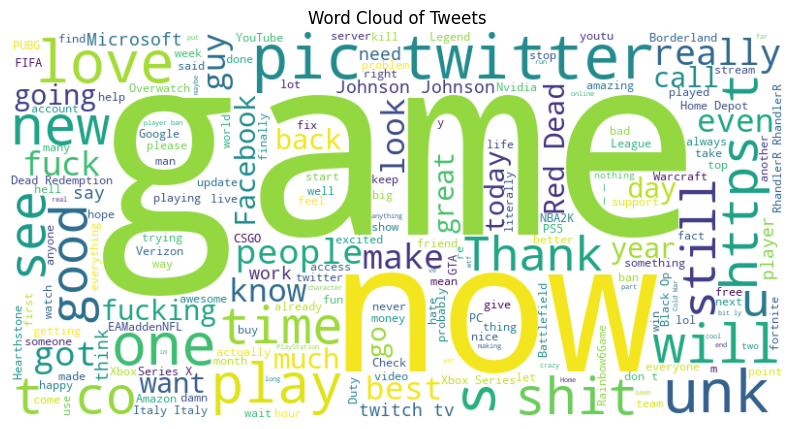

In [12]:
#visualizing the word cloud
# Concatenate all tweets into a single string
all_tweets_text = ' '.join(training_df['Tweet'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

In [13]:
#display the full content of the each cell
pd.set_option('display.max_colwidth',None)
train_df1=training_df[['response','Tweet']]
train_df1.head()

,response,Tweet
0,Positive,"I am coming to the borders and I will kill you all,"
1,Positive,"im getting on borderlands and i will kill you all,"
2,Positive,"im coming on borderlands and i will murder you all,"
3,Positive,"im getting on borderlands 2 and i will murder you me all,"
4,Positive,"im getting into borderlands and i can murder you all,"


In [14]:
train_df1['response'].value_counts()

response
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

# Preprocess Function

In [15]:
stop_words=nltk.corpus.stopwords.words('english')
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [16]:
#Data Cleaning Steps
def remove_punt(text):
    punctuations_free = "".join([char for char in text if char not in string.punctuation])
    return punctuations_free

def tokenization(text):
    tokens = re.split(' ', text)  # Split on non-alphanumeric characters
    return tokens

def remove_stop_words(text):
    output = [i for i in text if i.lower() not in stop_words]  # Case-insensitive check
    return output

def remove_numbers(text_list):
    text = ' '.join(text_list)
    text = re.sub(r'\d+', '', text)
    return text.split()

def remove_emoji(text_list):
    text = ' '.join(text_list)
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text.split()

def remove_url(text_list):
    text = ' '.join(text_list)
    url = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return url.split()

In [17]:
#Text Preprocessing with Lemmatization and POS Tagging
def preprocess(text):
    if not isinstance(text, str):
        raise ValueError("Input should be a string.")
 
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    def get_wordnet_pos(tag):
        if tag.startswith('V'):
            return 'v'  # verb
        elif tag.startswith('N'):
            return 'n'  # noun
        elif tag.startswith('R'):
            return 'r'  # adverb
        else:
            return 'a'  

    filtered_tokens = [
        lemmatizer.lemmatize(token.lower(), get_wordnet_pos(tag))  
        for token, tag in pos_tags
        if token.lower() not in stop_words and token not in string.punctuation
    ]
    return " ".join(filtered_tokens)


In [18]:
# Text Cleaning and Preprocessing Pipeline

train_df1['text_lower']=train_df1['Tweet'].apply(lambda x:x.lower())
train_df1['cleaned_text']=train_df1['text_lower'].apply(lambda x:remove_punt(x))
train_df1['numbers_removed']= train_df1['cleaned_text'].apply(lambda x:(remove_numbers(x)))
train_df1['url_removed']= train_df1['numbers_removed'].apply(lambda x:(remove_url(x))) 
train_df1['emoji_removed']= train_df1['url_removed'].apply(lambda x:(remove_emoji(x)))
train_df1['emoji_removed'] = train_df1['emoji_removed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
train_df1['tokenized_text']=train_df1['emoji_removed'].apply(lambda x:tokenization(x))
train_df1['no_stop_text']=train_df1['tokenized_text'].apply(lambda x:remove_stop_words(x))

C:\Users\user\AppData\Local\Temp\ipykernel_24308\1615197071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1['text_lower']=train_df1['Tweet'].apply(lambda x:x.lower())


In [19]:
train_df1['textPreprocessed']=train_df1['Tweet'].apply( preprocess)

In [20]:
train_df1

,response,Tweet,text_lower,cleaned_text,numbers_removed,url_removed,emoji_removed,tokenized_text,no_stop_text,textPreprocessed
0,Positive,"I am coming to the borders and I will kill you all,","i am coming to the borders and i will kill you all,",i am coming to the borders and i will kill you all,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, o, r, d, e, r, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, o, r, d, e, r, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]",i a m c o m i n g t o t h e b o r d e r s a n d i w i l l k i l l y o u a l l,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, o, r, d, e, r, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[c, n, g, h, e, b, r, e, r, n, w, l, l, k, l, l, u, l, l]",come border kill
1,Positive,"im getting on borderlands and i will kill you all,","im getting on borderlands and i will kill you all,",im getting on borderlands and i will kill you all,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]",i m g e t t i n g o n b o r d e r l a n d s a n d i w i l l k i l l y o u a l l,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, k, l, l, u, l, l]",im get borderland kill
2,Positive,"im coming on borderlands and i will murder you all,","im coming on borderlands and i will murder you all,",im coming on borderlands and i will murder you all,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, a, l, l]","[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, a, l, l]",i m c o m i n g o n b o r d e r l a n d s a n d i w i l l m u r d e r y o u a l l,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, a, l, l]","[c, n, g, n, b, r, e, r, l, n, n, w, l, l, u, r, e, r, u, l, l]",im come borderland murder
3,Positive,"im getting on borderlands 2 and i will murder you me all,","im getting on borderlands 2 and i will murder you me all,",im getting on borderlands 2 and i will murder you me all,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, m, e, a, l, l]","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, m, e, a, l, l]",i m g e t t i n g o n b o r d e r l a n d s a n d i w i l l m u r d e r y o u m e a l l,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, m, e, a, l, l]","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, u, r, e, r, u, e, l, l]",im get borderland 2 murder
4,Positive,"im getting into borderlands and i can murder you all,","im getting into borderlands and i can murder you all,",im getting into borderlands and i can murder you all,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, c, a, n, m, u, r, d, e, r, y, o, u, a, l, l]","[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, c, a, n, m, u, r, d, e, r, y, o, u, a, l, l]",i m g e t t i n g i n t o b o r d e r l a n d s a n d i c a n m u r d e r y o u a l l,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, c, a, n, m, u, r, d, e, r, y, o, u, a, l, l]","[g, e, n, g, n, b, r, e, r, l, n, n, c, n, u, r, e, r, u, l, l]",im get borderland murder
...,...,...,...,...,...,...,...,...,...,...
74676,Positive,Just realized that the Windows partition of my Mac is like 6 years behind Nvidia drivers and I have no idea how I did not notice,just realized that the windows partition of 

### Label Encoding the target column

In [21]:
#importing label encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [22]:
train_df1['response']=le.fit_transform(train_df1['response'])

In [23]:
train_df1

,response,Tweet,text_lower,cleaned_text,numbers_removed,url_removed,emoji_removed,tokenized_text,no_stop_text,textPreprocessed
0,3,"I am coming to the borders and I will kill you all,","i am coming to the borders and i will kill you all,",i am coming to the borders and i will kill you all,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, o, r, d, e, r, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, o, r, d, e, r, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]",i a m c o m i n g t o t h e b o r d e r s a n d i w i l l k i l l y o u a l l,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, o, r, d, e, r, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[c, n, g, h, e, b, r, e, r, n, w, l, l, k, l, l, u, l, l]",come border kill
1,3,"im getting on borderlands and i will kill you all,","im getting on borderlands and i will kill you all,",im getting on borderlands and i will kill you all,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]",i m g e t t i n g o n b o r d e r l a n d s a n d i w i l l k i l l y o u a l l,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, k, i, l, l, y, o, u, a, l, l]","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, k, l, l, u, l, l]",im get borderland kill
2,3,"im coming on borderlands and i will murder you all,","im coming on borderlands and i will murder you all,",im coming on borderlands and i will murder you all,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, a, l, l]","[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, a, l, l]",i m c o m i n g o n b o r d e r l a n d s a n d i w i l l m u r d e r y o u a l l,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, a, l, l]","[c, n, g, n, b, r, e, r, l, n, n, w, l, l, u, r, e, r, u, l, l]",im come borderland murder
3,3,"im getting on borderlands 2 and i will murder you me all,","im getting on borderlands 2 and i will murder you me all,",im getting on borderlands 2 and i will murder you me all,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, m, e, a, l, l]","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, m, e, a, l, l]",i m g e t t i n g o n b o r d e r l a n d s a n d i w i l l m u r d e r y o u m e a l l,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, w, i, l, l, m, u, r, d, e, r, y, o, u, m, e, a, l, l]","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, u, r, e, r, u, e, l, l]",im get borderland 2 murder
4,3,"im getting into borderlands and i can murder you all,","im getting into borderlands and i can murder you all,",im getting into borderlands and i can murder you all,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, c, a, n, m, u, r, d, e, r, y, o, u, a, l, l]","[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, c, a, n, m, u, r, d, e, r, y, o, u, a, l, l]",i m g e t t i n g i n t o b o r d e r l a n d s a n d i c a n m u r d e r y o u a l l,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, r, d, e, r, l, a, n, d, s, a, n, d, i, c, a, n, m, u, r, d, e, r, y, o, u, a, l, l]","[g, e, n, g, n, b, r, e, r, l, n, n, c, n, u, r, e, r, u, l, l]",im get borderland murder
...,...,...,...,...,...,...,...,...,...,...
74676,3,Just realized that the Windows partition of my Mac is like 6 years behind Nvidia drivers and I have no idea how I did not notice,just realized that the windows partition of my mac is like 6 years behind nvidia drive

## Split data into train and test

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train,X_test,y_train,y_test=train_test_split(train_df1['textPreprocessed'],train_df1['response'],test_size=0.2,random_state=42,stratify=train_df1['response'])

In [26]:
X_train.shape

(57324,)

In [27]:
X_test.shape

(14331,)

# Machine Learning Model


In [28]:
#Import necessary components for building a machine learning pipeline for text classification.
from sklearn.pipeline import Pipeline
#Includes text vectorization (TfidfVectorizer)
from sklearn.feature_extraction.text import TfidfVectorizer
#classification model (RandomForestClassifier)
from sklearn.ensemble import RandomForestClassifier
#import metrics (accuracy, confusion matrix, classification report) for evaluating the model's performance.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [29]:
#creating classifier
clr=Pipeline([('vectorizer',TfidfVectorizer()),
             ('random_forest',(RandomForestClassifier()))
             ])

In [30]:
#model training
clr.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('random_forest', RandomForestClassifier())])

In [31]:
#make prediction
y_pred = clr.predict(X_test)

In [32]:
print(accuracy_score(y_test,y_pred))

0.9134742865117578


In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      2507
           1       0.92      0.93      0.93      4340
           2       0.95      0.90      0.92      3542
           3       0.85      0.94      0.90      3942

    accuracy                           0.91     14331
   macro avg       0.92      0.91      0.91     14331
weighted avg       0.92      0.91      0.91     14331



# Testing Model

### loading test datasets

In [41]:
test_df=pd.read_csv("twitter-entity-sentiment-analysis/twitter_validation.csv",names =['index','company','response','tweet'])

In [42]:
test_df.head()

,index,company,response,tweet
0,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking, it's a truly awful game."
4,4433,Google,Neutral,Now the President is slapping Americans in the face that he really did commit an unlawful act after his acquittal! From Discover on Google vanityfair.com/news/2020/02/t…


In [58]:
test_text = test_df["tweet"][31]
print(f"{test_text} ==> {test_df['response'][31]}")

I don’t see how this looks like as Xbox controller but y’all will say anything. Anyway this is fire. ==> Positive


#### Apply preprocess

In [59]:
test_text_preprocessed = [preprocess(test_text)]
test_text_preprocessed

['’ see look like xbox controller ’ say anything anyway fire']

In [60]:
test_text = clr.predict(test_text_preprocessed)

# Output

In [61]:
classes = ['Irrelevant', 'Natural', 'Negative', 'Positive']

print(f"True Label: {test_df['response'][31]}")
print(f'Predict Label: {classes[test_text[0]]}')

True Label: Positive
Predict Label: Positive
